# **MIT 6.5940 EfficientML.ai Fall 2023: Lab 0 PyTorch**

In this tutorial, we will explore how to train a neural network with PyTorch.

### Setup

In [3]:
!pip install torchprofile 1>/dev/null

In [4]:
import random
from collections import OrderedDict, defaultdict

import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchprofile import profile_macs
from torchvision.datasets import *
from torchvision.transforms import *
from tqdm.auto import tqdm

In [5]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

### Data

We will use CIFAR-10 as our target dataset. This dataset contains images from 10 classes, where each image is of size 3x32x32, 3-channel color images of 32x32 pixels in size.

In [7]:
transforms = {
    'train': Compose([
        RandomCrop(32, padding=4),
        RandomHorizontalFlip(),
        ToTensor(),
    ]),
    'test': Compose([
        ToTensor(),
    ])
}

dataset = {}
for split in ['train', 'test']:
    dataset[split] = CIFAR10(
        root='data/cifar10',
        train=(split == 'train'),
        download=True,
        transform=transforms[split],
    )

Files already downloaded and verified
Files already downloaded and verified


Let's visualize a few images in the dataset and their corresponding class labels:

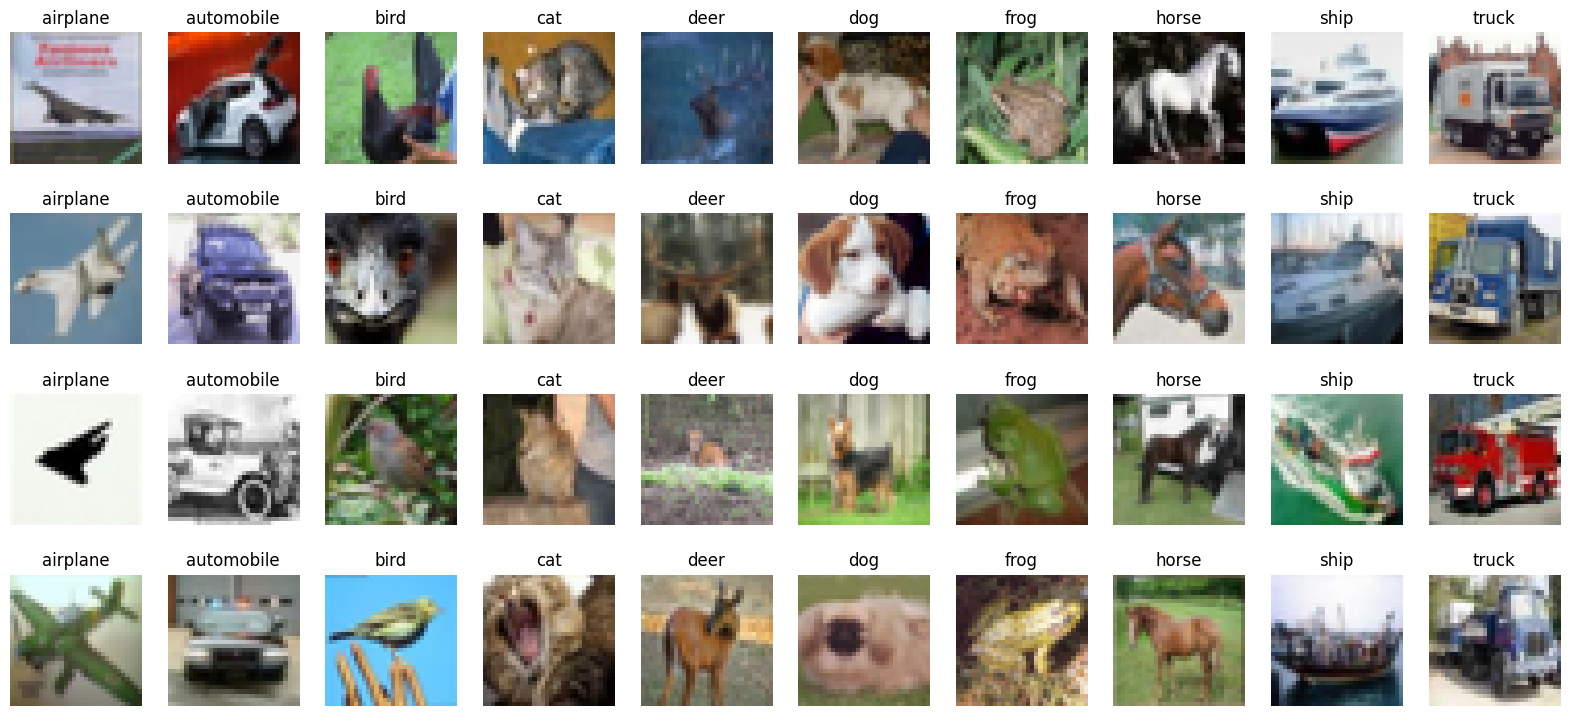

In [8]:
samples = [[] for _ in range(10)]
for image, label in dataset['test']:
    samples[label].append(image)

plt.figure(figsize=(20, 9))
for idx in range(40):
    label = idx % 10
    image = samples[label][idx // 10]

    # Convert from CHW to HWC for visualization
    image = image.permute(1, 2, 0)

    # Convert from class index to class name
    label = dataset['test'].classes[label]

    # Visualize
    plt.subplot(4, 10, idx + 1)
    plt.imshow(image)
    plt.title(label)
    plt.axis('off')
plt.show()

In [9]:
dataflow = {}
for split in ['train', 'test']:
    dataflow[split] = DataLoader(
        dataset[split],
        batch_size=512,
        shuffle=(split == 'train'),
        num_workers=0,
        pin_memory=True,
    )

In [10]:
for inputs, targets in dataflow['train']:
    print('[inputs] dtype: {}, shape: {}'.format(inputs.dtype, inputs.shape))
    print('[targets] dtype: {}, shape: {}'.format(targets.dtype, targets.shape))
    break

[inputs] dtype: torch.float32, shape: torch.Size([512, 3, 32, 32])
[targets] dtype: torch.int64, shape: torch.Size([512])


### Model

In [14]:
class VGG(nn.Module):
    ARCH = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

    def __init__(self) -> None:
        super().__init__()

        layers = []
        counts = defaultdict(int)

        def add(name: str, layer: nn.Module) -> None:
            layers.append((f'{name}{counts[name]}', layer))
            counts[name] += 1

        in_channels = 3
        for x in self.ARCH:
            if x != 'M':
                # conv-bn-relu
                add('conv', nn.Conv2d(in_channels, x, 3, padding=1, bias=False))
                add('bn', nn.BatchNorm2d(x))
                add('relu', nn.ReLU(True))
                in_channels = x
            else:
                # maxpool
                add('pool', nn.MaxPool2d(2))

        self.backbone = nn.Sequential(OrderedDict(layers))
        self.classifier = nn.Linear(512, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # backbone: [N, 3, 32, 32] -> [N, 512, 2, 2]
        x = self.backbone(x)

        # avgpool: [N, 512, 2, 2] -> [N, 512]
        x = x.mean([2, 3])

        # classifier: [N, 512] -> [N, 10]
        x = self.classifier(x)
        return x

model = VGG().cuda()

Its backbone is composed of 8 ```conv-bn-relu``` blocks interleaved with 4 ```maxpool```'s to downsample the feature map by 2^4 = 16 times:

In [15]:
print(model.backbone)

Sequential(
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu0): ReLU(inplace=True)
  (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace=True)
  (pool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace=True)
  (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU(inplace=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

After the feature map is pooled, its classifier predicts the final output with a linear layer:

In [16]:
print(model.classifier)

Linear(in_features=512, out_features=10, bias=True)


Model size can be estimated by the number of trainable parameters:

In [17]:
num_params = 0
for param in model.parameters():
    if param.requires_grad:
        num_params += param.numel()
print('#Params: ', num_params)

#Params:  9228362


The computation cost can be estimated by the number of multiply-accumulate operations (MACs) using TorchProfile:

In [18]:
num_macs = profile_macs(model, torch.zeros(1, 3, 32, 32).cuda())
print('#MACs: ', num_macs)

#MACs:  606164480


This model has 9.2M parameters and requires 606M MACs for inference.

### Optimization

As this problem is classification, we will apply cross entropy as our loss function to optimize the model:

In [19]:
criterion = nn.CrossEntropyLoss()

Optimization will be carried out using stochastic gradient descent (SGD) with momentum:

In [20]:
optimizer = SGD(
    model.parameters(),
    lr=0.4,
    momentum=0.9,
    weight_decay=5e-4,
)

The learning rate will be modulated using the following scheduler:

In [ ]:
num_epochs = 20
steps_per_epoch = len(dataflow['train'])

# Define the piecewise linear scheduler
lr_lambda = lambda step: np.interp(
    [step / steps_per_epoch],
    [0, num_epochs * 0.3, num_epochs],
    [0, 1, 0]
)[0]

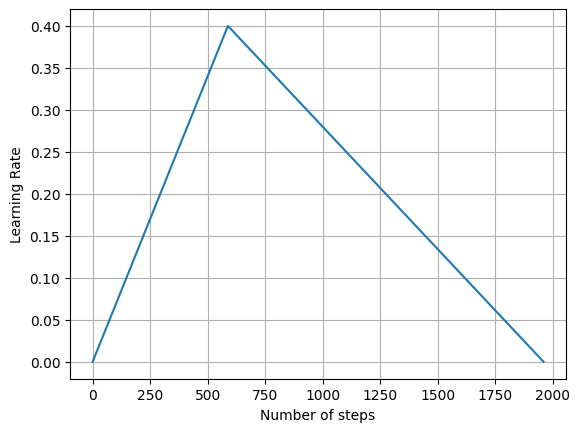

In [26]:
steps = np.arange(steps_per_epoch * num_epochs)
plt.plot(steps, [lr_lambda(step) * 0.4 for step in steps])
plt.xlabel('Number of steps')
plt.ylabel('Learning Rate')
plt.grid('on')
plt.show()

scheduler = LambdaLR(optimizer, lr_lambda)

### Training

In [27]:
def train(
        model: nn.Module,
        criterion: nn.Module,
        optimizer: Optimizer,
        scheduler: LambdaLR,
        dataflow: DataLoader,
) -> None:
    model.train()

    for inputs, targets in tqdm(dataflow, desc='Training', leave=False):
        # Move the data from CPU to GPU
        inputs = inputs.cuda()
        targets = targets.cuda()

        # Reset the gradients (from the last iteration)
        optimizer.zero_grad()

        # Forward inference
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward propagation
        loss.backward()

        # Update optimizer and LR scheduler
        optimizer.step()
        scheduler.step()

In [29]:
@torch.inference_mode()
def evaluate(
        model: nn.Module,
        dataflow: DataLoader,
) -> float:
    model.eval()

    num_samples = 0
    num_correct = 0

    for inputs, targets in tqdm(dataflow, desc='Evaluating', leave=False):
        # Move the data from CPU to GPU
        inputs = inputs.cuda()
        targets = targets.cuda()

        # Forward inference
        outputs = model(inputs)

        # Convert logits to class indices
        outputs = outputs.argmax(dim=1)

        # Update metrics
        num_samples += targets.size(0)
        num_correct += (outputs == targets).sum()

    return (num_correct / num_samples * 100).item()


In [30]:
for epoch_num in tqdm(range(1, num_epochs + 1)):
    train(model, criterion, optimizer, scheduler, dataflow['train'])
    metric = evaluate(model, dataflow['test'])
    print(f'Epoch {epoch_num}, Test Accuracy: {metric:.2f}%')


  0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/98 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1, Test Accuracy: 48.39%


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2, Test Accuracy: 54.73%


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3, Test Accuracy: 51.05%


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4, Test Accuracy: 63.54%


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5, Test Accuracy: 71.97%


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 6, Test Accuracy: 75.39%


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 7, Test Accuracy: 61.48%


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 8, Test Accuracy: 72.79%


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 9, Test Accuracy: 70.91%


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 10, Test Accuracy: 79.63%


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 11, Test Accuracy: 78.55%


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 12, Test Accuracy: 84.77%


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 13, Test Accuracy: 75.27%


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 14, Test Accuracy: 77.68%


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 15, Test Accuracy: 81.81%


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 16, Test Accuracy: 85.41%


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 17, Test Accuracy: 88.84%


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 18, Test Accuracy: 89.76%


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 19, Test Accuracy: 91.84%


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 20, Test Accuracy: 92.61%


### Visualization

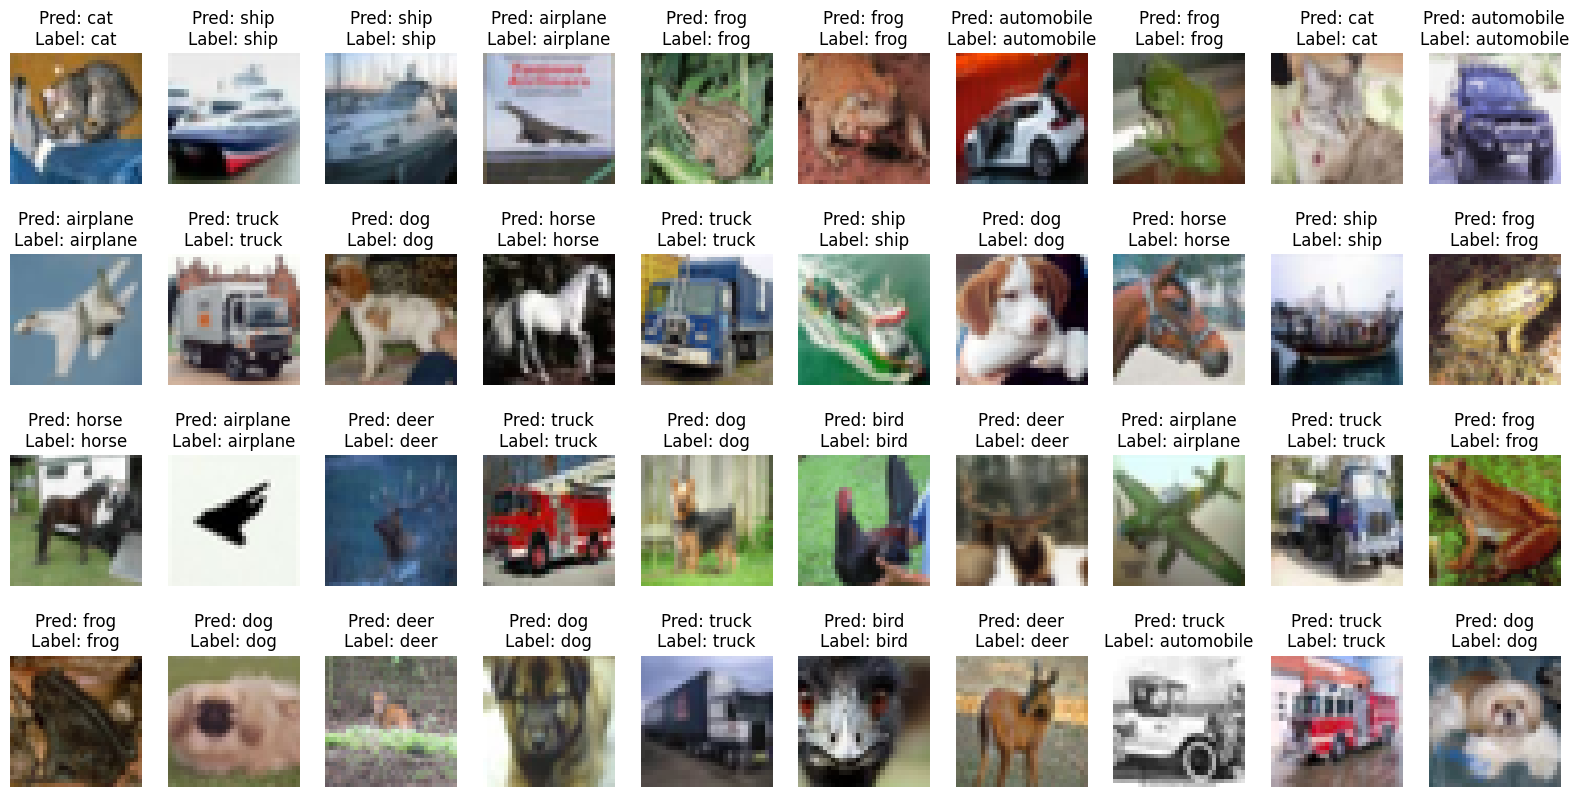

In [34]:
plt.figure(figsize=(20, 10))
for idx in range(40):
    image, label = dataset['test'][idx]

    # Model inference
    model.eval()
    with torch.inference_mode():
        pred = model(image.unsqueeze(dim=0).cuda())
        pred = pred.argmax(dim=1)

    # Convert from CHW to HWC for visualization
    image = image.permute(1, 2, 0)

    # Convert from class indices to class names
    pred = dataset['test'].classes[pred]
    label = dataset['test'].classes[label]


    # Visualize
    plt.subplot(4, 10, idx + 1)
    plt.imshow(image)
    plt.title(f'Pred: {pred}\nLabel: {label}')
    plt.axis('off')
plt.show()
